In [46]:
import random
import numpy as np
import tqdm
from matplotlib import pyplot as plt
import torch
import torchvision
from torchsummary import summary
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter

import img_text_composition_models
import datasets

In [47]:
logger = SummaryWriter("./logs/mitstates_tests")

In [48]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [49]:
def load_dataset():
    """Loads the input datasets."""
    dataset = "mitstates"
    path = "./data/mitstates/"

    trainset = datasets.MITStates(
        path=path,
        split="train",
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(224),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
                ),
            ]
        ),
    )
    testset = datasets.MITStates(
        path=path,
        split="test",
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(224),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
                ),
            ]
        ),
    )

    print("trainset size:", len(trainset))
    print("testset size:", len(testset))
    return trainset, testset

In [50]:
trainset, testset = load_dataset()

82732 test queries
trainset size: 43207
testset size: 10546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------
Shape: torch.Size([3, 224, 224])


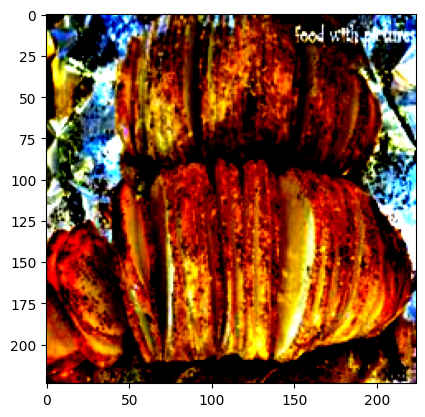

Text: sliced potato
Label: {'str': 'crushed'}
------------------------
Target image shape: torch.Size([3, 224, 224])


In [87]:
# plot a sample image
# dict_keys(['source_img_id', 'source_img_data', 'source_caption', 'target_img_id', 'target_img_data', 'noun', 'target_caption', 'mod'])
test_idx = random.randint(0, len(testset))
img, text, label = (
    testset[test_idx]["source_img_data"],
    testset[test_idx]["source_caption"],
    testset[test_idx]["mod"],
)
img_y_true, text_y_true, label_y_true = (
    testset[test_idx]["target_img_data"],
    testset[test_idx]["target_caption"],
    testset[test_idx]["noun"],
)
print("------" * 4)
print("Shape:", img.shape)
# plot image
plt.imshow(img.permute(1, 2, 0))
plt.show()
print("Text:", text)
print("Label:", label)
print("------" * 4)
print("Target image shape:", img_y_true.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


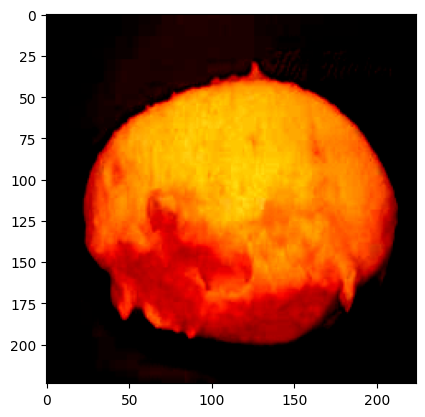

Target text: mashed potato
Target label: potato


In [88]:
# plot image
plt.imshow(img_y_true.permute(1, 2, 0))
plt.show()
print("Target text:", text_y_true)
print("Target label:", label_y_true)

In [53]:
texts = [t for t in trainset.get_all_texts()]
len(texts)

43207

In [54]:
model = img_text_composition_models.TIRG(
    texts, image_embed_dim=512, text_embed_dim=512, use_bert=False, name="tirg"
)
model

TIRG(
  (normalization_layer): NormalizationLayer()
  (soft_triplet_loss): TripletLoss()
  (img_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [55]:
model_checkpoint_path = (
    "./logs/mitstates/Aug31_12-54-16_dev3mitstates_tirg_original/latest_checkpoint.pth"
)
checkpoint = torch.load(model_checkpoint_path)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [56]:
model = model.cuda()

In [58]:
# Create a dummy input for the image and text model. This is just an example, you'd need to adjust the shape and data type as per your actual input.
dummy_img_input = torch.randn(1, 3, 224, 224).cuda()
dummy_text_input = torch.randint(
    0, 311, (1, 100)
).cuda()  # Assuming 100 as sequence length
dummy_img_target = torch.randn(1, 3, 224, 224).cuda()

# Add the model and dummy input to the writer
logger.add_graph(model, [dummy_img_input, dummy_text_input, dummy_img_target])

AssertionError: 

In [33]:
# plot model architecture
summary(model.img_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [35]:
summary(model.text_model, (32, 512))

AssertionError: 

Namespace(batch_size=32, category_to_train='all', comment='mitstates_tirg_test', dataset='mitstates', dataset_path='./data/mitstates/', f='', image_embed_dim=512, learning_rate=0.01, learning_rate_decay_frequency=9999999, loader_num_workers=4, log_dir='./logs/mitstates/', loss='soft_triplet', model='tirg', model_checkpoint='./logs/mitstates/Aug28_16-42-37_dev3mitstates_tirg_original/latest_checkpoint.pth', num_iters=160000, test_only=True, use_bert=False, use_complete_text_query=False, weight_decay=1e-06)

In [ ]:
def _test(model, testset):
    """Tests a model over the given testset."""
    use_complete_text_query = False
    batch_size = 32

    model.eval()
    test_queries = testset.get_test_queries()

    all_imgs = []
    all_captions = []
    all_queries = []
    all_target_captions = []
    if test_queries:
        imgs = []
        mods = []
        for t in tqdm(test_queries):
            torch.cuda.empty_cache()
            imgs += [testset.get_img(t["source_img_id"])]
            if use_complete_text_query:
                mods += [t["mod"]["str"] + " " + t["noun"]]
            else:
                mods += [t["mod"]["str"]]

            if len(imgs) >= batch_size or t is test_queries[-1]:
                if "torch" not in str(type(imgs[0])):
                    imgs = [torch.from_numpy(d).float() for d in imgs]
                imgs = torch.stack(imgs).float()
                imgs = torch.autograd.Variable(imgs).cuda()
                dct_with_representations = model.compose_img_text(imgs.cuda(), mods)
                f = dct_with_representations["repres"].data.cpu().numpy()
                all_queries += [f]
                imgs = []
                mods = []
        all_queries = np.concatenate(all_queries)
        all_target_captions = [t["target_caption"] for t in test_queries]

        # compute all image features
        imgs = []
        for i in tqdm(range(len(testset.imgs))):
            imgs += [testset.get_img(i)]
            if len(imgs) >= batch_size or i == len(testset.imgs) - 1:
                if "torch" not in str(type(imgs[0])):
                    imgs = [torch.from_numpy(d).float() for d in imgs]
                imgs = torch.stack(imgs).float()
                imgs = torch.autograd.Variable(imgs).cuda()
                imgs = model.extract_img_feature(imgs.cuda()).data.cpu().numpy()

                all_imgs += [imgs]
                imgs = []
        all_imgs = np.concatenate(all_imgs)
        all_captions = [img["captions"][0] for img in testset.imgs]

    else:
        # use training queries to approximate training retrieval performance
        imgs0 = []
        imgs = []
        mods = []
        training_approx = 9600
        for i in range(training_approx):
            torch.cuda.empty_cache()
            item = testset[i]
            imgs += [item["source_img_data"]]
            if use_complete_text_query:
                mods += [item["mod"]["str"] + " " + item["noun"]]
            else:
                mods += [item["mod"]["str"]]

            if len(imgs) >= batch_size or i == training_approx:
                imgs = torch.stack(imgs).float()
                imgs = torch.autograd.Variable(imgs)
                dct_with_representations = model.compose_img_text(imgs.cuda(), mods)
                f = dct_with_representations["repres"].data.cpu().numpy()
                all_queries += [f]
                imgs = []
                mods = []
            imgs0 += [item["target_img_data"]]
            if len(imgs0) >= batch_size or i == training_approx:
                imgs0 = torch.stack(imgs0).float()
                imgs0 = torch.autograd.Variable(imgs0)
                imgs0 = model.extract_img_feature(imgs0.cuda()).data.cpu().numpy()
                all_imgs += [imgs0]
                imgs0 = []
            all_captions += [item["target_caption"]]
            all_target_captions += [item["target_caption"]]
        all_imgs = np.concatenate(all_imgs)
        all_queries = np.concatenate(all_queries)

    # feature normalization
    for i in range(all_queries.shape[0]):
        all_queries[i, :] /= np.linalg.norm(all_queries[i, :])
    for i in range(all_imgs.shape[0]):
        all_imgs[i, :] /= np.linalg.norm(all_imgs[i, :])

    # match test queries to target images, get nearest neighbors
    sims = all_queries.dot(all_imgs.T)
    if test_queries:
        for i, t in enumerate(test_queries):
            sims[i, t["source_img_id"]] = -10e10  # remove query image
    nn_result = [np.argsort(-sims[i, :])[:110] for i in range(sims.shape[0])]

    # compute recalls
    out = []
    nn_result = [[all_captions[nn] for nn in nns] for nns in nn_result]
    for k in [1, 5, 10, 50, 100]:
        r = 0.0
        for i, nns in enumerate(nn_result):
            if all_target_captions[i] in nns[:k]:
                r += 1
        r /= len(nn_result)
        out += [("recall_top" + str(k) + "_correct_composition", r)]

        r = 0.0
        for i, nns in enumerate(nn_result):
            if all_target_captions[i].split()[0] in [c.split()[0] for c in nns[:k]]:
                r += 1
        r /= len(nn_result)
        out += [("recall_top" + str(k) + "_correct_adj", r)]

        r = 0.0
        for i, nns in enumerate(nn_result):
            if all_target_captions[i].split()[1] in [c.split()[1] for c in nns[:k]]:
                r += 1
        r /= len(nn_result)
        out += [("recall_top" + str(k) + "_correct_noun", r)]

    return out

In [ ]:
it = checkpoint["it"]
model.eval()
tests = []
it = 0
for name, dataset in [("train", trainset), ("test", testset)]:
    t = _test(model, dataset)
tests += [(name + " " + metric_name, metric_value) for metric_name, metric_value in t]
for metric_name, metric_value in tests:
    # logger.add_scalar(metric_name, metric_value, it)
    print("    ", metric_name, round(metric_value, 4))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same